In [1]:
import warnings
import pprint
# from itertools import islice
# import tqdm
# import matplotlib.pyplot as plt
# import pygraphviz as pgv
# from networkx.drawing.nx_agraph import graphviz_layout


warnings.filterwarnings('ignore')


___
## Index Connection & Inspection

### Index Connection

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import connections

Connect to Elasticsearch(ES) index: `smartapi_metakg_docs_consolidated`:  

In [3]:
es = Elasticsearch() # set ES obj
index = "smartapi_metakg_docs_consolidated" # set index name
connections.create_connection(hosts=['localhost']) # create a connection


<Elasticsearch([{'host': 'localhost'}])>

### Index Inspection

Get some index stats

In [4]:
stats = es.indices.stats(index=index)
pprint.pprint(stats)

{'_all': {'primaries': {'completion': {'size_in_bytes': 0},
                        'docs': {'count': 167827, 'deleted': 0},
                        'fielddata': {'evictions': 0,
                                      'memory_size_in_bytes': 0},
                        'flush': {'periodic': 0,
                                  'total': 1,
                                  'total_time_in_millis': 0},
                        'get': {'current': 0,
                                'exists_time_in_millis': 0,
                                'exists_total': 0,
                                'missing_time_in_millis': 0,
                                'missing_total': 0,
                                'time_in_millis': 0,
                                'total': 0},
                        'indexing': {'delete_current': 0,
                                     'delete_time_in_millis': 0,
                                     'delete_total': 0,
                                     'index_current

Get index information - The `_settings` and `_mappings` endpoints give you information about the index's settings and mappings.

In [5]:
settings = es.indices.get_settings(index=index)
pprint.pprint(settings)

mappings = es.indices.get_mapping(index=index)
pprint.pprint(mappings)

{'smartapi_metakg_docs_consolidated': {'settings': {'index': {'analysis': {'normalizer': {'lowercase_normalizer': {'filter': ['lowercase'],
                                                                                                                   'type': 'custom'}}},
                                                              'creation_date': '1689880111211',
                                                              'mapping': {'ignore_malformed': 'true',
                                                                          'total_fields': {'limit': '2500'}},
                                                              'number_of_replicas': '0',
                                                              'number_of_shards': '1',
                                                              'provided_name': 'smartapi_metakg_docs_consolidated',
                                                              'routing': {'allocation': {'include': {'_tier_preference': 'da

Get document count

In [6]:
doc_count = es.count(index=index)['count']
print(f"Document count: {doc_count}")


Document count: 167827


Sample Docs - If you want to quickly fetch a few documents to inspect their structure, you can use the search method with a size limit.

In [7]:
sample_docs = es.search(index=index, size=5)
for doc in sample_docs['hits']['hits']:
    pprint.pprint(doc['_source'])


{'api': [{'bte': {'query_operation': {'input_separator': ',',
                                      'method': 'post',
                                      'params': None,
                                      'path': '/query',
                                      'path_params': None,
                                      'request_body': None,
                                      'server': 'https://cam-kp-api.renci.org/1.3.0',
                                      'support_batch': True}},
          'name': 'CAM-KP API',
          'smartapi': {'id': '642b1dbcd0943f3a119d714cf7535fba',
                       'metadata': 'https://cam-kp-api.renci.org/1.3.0/docs/docs.yaml',
                       'ui': 'https://smart-api.info/ui/642b1dbcd0943f3a119d714cf7535fba'},
          'tags': ['maturity', 'translator', 'trapi', 'bte-trapi'],
          'x-translator': {'component': 'KP', 'team': ['Exposures Provider']}},
         {'bte': {'query_operation': {'input_separator': ',',
                 

Field Statistics - The `field_stats` method (in older versions of ES) or the `field_caps` method (in newer versions) can give statistics about fields within the index. For example:

In [8]:
field_info = es.field_caps(index=index, fields="*")
pprint.pprint(field_info)


{'fields': {'_data_stream_timestamp': {'_data_stream_timestamp': {'aggregatable': False,
                                                                  'metadata_field': True,
                                                                  'searchable': False,
                                                                  'type': '_data_stream_timestamp'}},
            '_doc_count': {'integer': {'aggregatable': False,
                                       'metadata_field': True,
                                       'searchable': False,
                                       'type': 'integer'}},
            '_feature': {'_feature': {'aggregatable': False,
                                      'metadata_field': True,
                                      'searchable': False,
                                      'type': '_feature'}},
            '_field_names': {'_field_names': {'aggregatable': False,
                                              'metadata_field': True,
      

---

## Generate Graph

Using the `path_finder` package

In [9]:
from utils.metakg import path_finder
import matplotlib.pyplot as plt
import networkx as nx


In [10]:
mkg = path_finder.MetaKGPathFinder()

Lets set a full a graph:

In [11]:
G_full=mkg.generate_networkx_graph()

After a quick inspection we see the expected number of edges in a full metakg graph extracted:

In [12]:
mkg.graph_inspection(G_full)

Graph type: <class 'networkx.classes.multidigraph.MultiDiGraph'>
Number of nodes: 113
Number of edges: 167827

Nodes:
ChemicalEntity
PlanetaryEntity
ThingWithTaxon
AnatomicalEntity
BiologicalEntity

Edges:
Edge: ChemicalEntity -> PlanetaryEntity, Predicate=negatively_regulates
Edge: ChemicalEntity -> PlanetaryEntity, Predicate=participates_in
Edge: ChemicalEntity -> PlanetaryEntity, Predicate=positively_regulates
Edge: ChemicalEntity -> PlanetaryEntity, Predicate=actively_involved_in
Edge: ChemicalEntity -> PlanetaryEntity, Predicate=actively_involves


Now we will filter the graph so we can do quick testing on the pathway finder

In [13]:
# query filter to find BTE data only
query_data = {
    'q': 'api.name:BTE'
}

In [14]:
G_bte=mkg.generate_networkx_graph(query_data=query_data)

In [15]:
mkg.graph_inspection(G_bte)

Graph type: <class 'networkx.classes.multidigraph.MultiDiGraph'>
Number of nodes: 43
Number of edges: 1827

Nodes:
ChemicalEntity
Cell
CellularComponent
GrossAnatomicalStructure
BiologicalProcess

Edges:
Edge: ChemicalEntity -> Cell, Predicate=part_of
Edge: ChemicalEntity -> Cell, Predicate=affects
Edge: ChemicalEntity -> Cell, Predicate=disrupts
Edge: ChemicalEntity -> Cell, Predicate=interacts_with
Edge: ChemicalEntity -> Cell, Predicate=produced_by


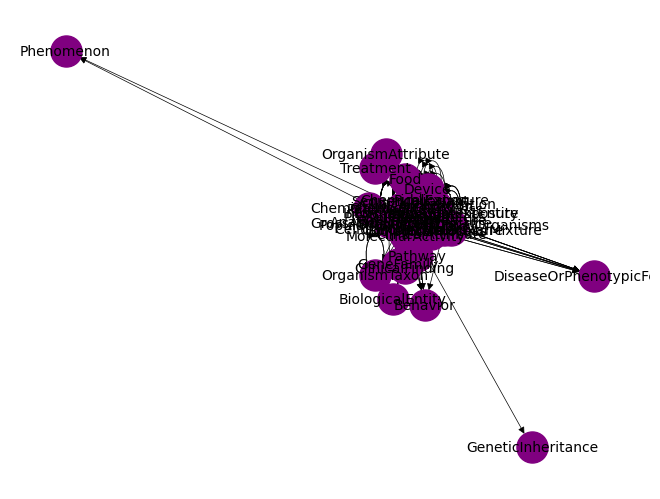

In [17]:
# Draw the graph
pos = nx.spring_layout(G_bte)  # This positions the nodes using the Fruchterman-Reingold force-directed algorithm.
nx.draw(G_bte, pos, with_labels=True, node_size=500, node_color='purple', font_size=10, width=0.5)
plt.show()

---